In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Roberta

# Preprocessing

Label distribution:
article_bias
3    92
2    72
1    32
4    19
Name: count, dtype: int64


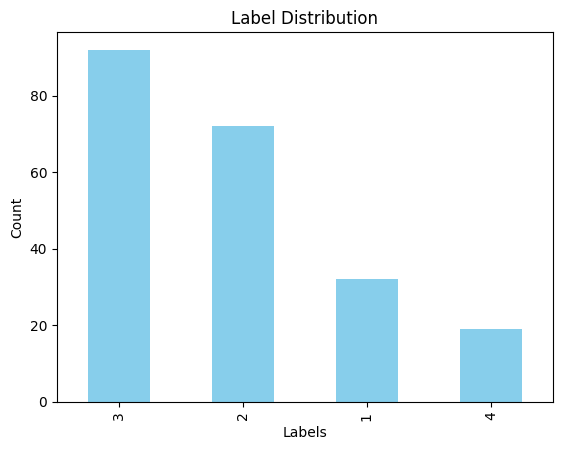

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('biased_sents.csv')

print("Label distribution:")
print(df['article_bias'].value_counts())

df['article_bias'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()


In [ ]:
df = pd.read_csv('biased_sents.csv')

class_counts = df['article_bias'].value_counts()

print("Label Counts:")
print(class_counts)

total_count = len(df)
class_percentages = (class_counts / total_count) * 100

print("\nLabel Percentages:")
print(class_percentages)

imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance ratio (max_count / min_count): {imbalance_ratio:.2f}")


Label Counts:
article_bias
3    92
2    72
1    32
4    19
Name: count, dtype: int64

Label Percentages:
article_bias
3    42.790698
2    33.488372
1    14.883721
4     8.837209
Name: count, dtype: float64

Imbalance ratio (max_count / min_count): 4.84


# Oversampling for Balance

In [ ]:
df = pd.read_csv('biased_sents.csv')

df = df[['docbody', 'article_bias']].dropna()

label_counts = df['article_bias'].value_counts()
print("Original label distribution:")
print(label_counts)

max_count = label_counts.max()
print(f"\nLargest class size: {max_count}")

balanced_df = df.groupby('article_bias').apply(
    lambda x: x.sample(max_count, replace=True)
).reset_index(drop=True)

new_label_counts = balanced_df['article_bias'].value_counts()
print("\nNew label distribution after oversampling:")
print(new_label_counts)

balanced_df.to_csv('biased_sents_balanced.csv', index=False)


Original label distribution:
article_bias
3    92
2    72
1    32
4    19
Name: count, dtype: int64

Largest class size: 92

New label distribution after oversampling:
article_bias
1    92
2    92
3    92
4    92
Name: count, dtype: int64


<ipython-input-4-085d2248d590>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('article_bias').apply(


# Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from datasets import Dataset


from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

def main():
  # data = pd.read_csv('biased_sents_balanced')
    data = pd.read_csv('biased_sents_balanced.csv')


    # Preprocess: select relevant columns and remove NaNs
    # Assuming columns are: docbody (text) and article_bias (label)
    data = data[['docbody', 'article_bias']].dropna()
    data.rename(columns={'docbody': 'text', 'article_bias': 'label'}, inplace=True)

    # Split dataset into train/val/test
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        data['text'],
        data['label'],
        test_size=0.3,        # 70% train, 30% temp
        random_state=42
    )
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts,
        temp_labels,
        test_size=0.5,        # 15% val, 15% test
        random_state=42
    )

    # Convert to Hugging Face Dataset
    train_dataset = Dataset.from_dict({'text': train_texts.tolist(), 'label': train_labels.tolist()})
    val_dataset = Dataset.from_dict({'text': val_texts.tolist(), 'label': val_labels.tolist()})
    test_dataset = Dataset.from_dict({'text': test_texts.tolist(), 'label': test_labels.tolist()})

    # Make label indexing start at 0
    unique_labels = sorted(data['label'].unique())
    label_map = {label: i for i, label in enumerate(unique_labels)}
    train_dataset = train_dataset.map(lambda x: {'label': label_map[x['label']]})
    val_dataset = val_dataset.map(lambda x: {'label': label_map[x['label']]})
    test_dataset = test_dataset.map(lambda x: {'label': label_map[x['label']]})

    ####################################################
    # 2. INITIALIZE TOKENIZER AND MODEL (RoBERTa-BASE)
    ####################################################
    roberta_model_name = "roberta-base"
    tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        roberta_model_name,
        num_labels=len(label_map)
    )

    ####################################################
    # 3. TOKENIZE THE DATA
    ####################################################
    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            truncation=True,
            padding='max_length',
            max_length=512
        )

    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)

    # Format the datasets for PyTorch
    tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    tokenized_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    # Setup
    training_args = TrainingArguments(
        output_dir="./results_roberta",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        # learning_rate = 5e-1,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_dir="./logs_roberta",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="none"
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = logits.argmax(axis=-1)
        return {
            "accuracy": accuracy_score(labels, predictions),
            "f1": f1_score(labels, predictions, average="weighted"),
            "precision": precision_score(labels, predictions, average="weighted"),
            "recall": recall_score(labels, predictions, average="weighted"),
        }


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )


    trainer.train()

    # Evaluate on validation set
    print("Evaluating on validation set...")
    val_results = trainer.evaluate(eval_dataset=tokenized_val)
    print(f"Validation Results: {val_results}")

    # Evaluate on test set
    print("Evaluating on test set...")
    test_results = trainer.evaluate(eval_dataset=tokenized_test)
    print(f"Test Results: {test_results}")

    test_results = trainer.evaluate(eval_dataset=tokenized_test)
    print(test_results)

if __name__ == "__main__":
    main()


Map:   0%|          | 0/257 [00:00<?, ? examples/s]

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/257 [00:00<?, ? examples/s]

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-4b5d0a2d2815>:110: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.392573,0.109091,0.021461,0.011901,0.109091
2,No log,1.347172,0.345455,0.237411,0.277481,0.345455
3,No log,1.269976,0.400000,0.368290,0.470740,0.400000
4,No log,1.261171,0.400000,0.348747,0.461403,0.400000
5,No log,1.252754,0.381818,0.302843,0.329394,0.381818


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating on validation set...


Validation Results: {'eval_loss': 1.2699756622314453, 'eval_accuracy': 0.4, 'eval_f1': 0.3682900432900433, 'eval_precision': 0.4707397865292602, 'eval_recall': 0.4, 'eval_runtime': 1.5596, 'eval_samples_per_second': 35.265, 'eval_steps_per_second': 2.565, 'epoch': 5.0}
Evaluating on test set...
Test Results: {'eval_loss': 1.317160725593567, 'eval_accuracy': 0.375, 'eval_f1': 0.3569325204263614, 'eval_precision': 0.39897959183673465, 'eval_recall': 0.375, 'eval_runtime': 1.5215, 'eval_samples_per_second': 36.805, 'eval_steps_per_second': 2.629, 'epoch': 5.0}
{'eval_loss': 1.317160725593567, 'eval_accuracy': 0.375, 'eval_f1': 0.3569325204263614, 'eval_precision': 0.39897959183673465, 'eval_recall': 0.375, 'eval_runtime': 1.5273, 'eval_samples_per_second': 36.666, 'eval_steps_per_second': 2.619, 'epoch': 5.0}


# Removing stopwords

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

df = pd.read_csv("biased_sents.csv")

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    # Split text into tokens
    tokens = text.split()
    # Remove stopwords
    tokens_no_stopwords = [word for word in tokens if word.lower() not in stop_words]
    # Rejoin tokens into a single string
    return " ".join(tokens_no_stopwords)

# Apply the stopword removal to the 'docbody' column
df['docbody'] = df['docbody'].apply(remove_stopwords)

# Save the cleaned dataset to a new CSV
df.to_csv("biased_sents_no_stopwords.csv", index=False)

print("Stopwords removed and saved to 'biased_sents_no_stopwords.csv'")


Stopwords removed and saved to 'biased_sents_no_stopwords.csv'


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# New Approach

# SVM

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = pd.read_csv("biased_sents_balanced.csv")

# Data Preprocessing
df = df[['docbody', 'article_bias']].dropna()

# Optional: Text cleaning (remove punctuation, normalize spaces, etc.)
import re
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

df['docbody'] = df['docbody'].apply(clean_text)


train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['docbody'], df['article_bias'], test_size=0.3, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Unigrams and bigrams
X_train = tfidf.fit_transform(train_texts)
X_val = tfidf.transform(val_texts)
X_test = tfidf.transform(test_texts)

# Train
svm = SVC(kernel='linear', C=1, random_state=42)  # Linear kernel for text classification
svm.fit(X_train, train_labels)

# Validation Set
val_predictions = svm.predict(X_val)
print("Validation Results:")
print(f"Accuracy: {accuracy_score(val_labels, val_predictions):.4f}")
print("Classification Report:")
print(classification_report(val_labels, val_predictions))

# Test Set
test_predictions = svm.predict(X_test)
print("Test Results:")
print(f"Accuracy: {accuracy_score(test_labels, test_predictions):.4f}")
print("Classification Report:")
print(classification_report(test_labels, test_predictions))

# Save
import joblib
joblib.dump(svm, "svm_bias_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("Model and vectorizer saved.")


Validation Results:
Accuracy: 0.3636
Classification Report:
              precision    recall  f1-score   support

           1       0.35      0.33      0.34        18
           2       0.12      0.33      0.17         6
           3       0.50      0.14      0.22        14
           4       0.59      0.59      0.59        17

    accuracy                           0.36        55
   macro avg       0.39      0.35      0.33        55
weighted avg       0.44      0.36      0.37        55

Test Results:
Accuracy: 0.5179
Classification Report:
              precision    recall  f1-score   support

           1       0.36      0.36      0.36        14
           2       0.62      0.59      0.61        17
           3       0.62      0.42      0.50        12
           4       0.50      0.69      0.58        13

    accuracy                           0.52        56
   macro avg       0.53      0.51      0.51        56
weighted avg       0.53      0.52      0.52        56

Model and vector